## Machine Learning I / Mini Lab Predictive Analysis
<b>Authors:</b> Fabio Savorgnon, Tina Pai, Paritosh Rai, Ellen Lull
<br><b>Data set from:</b> https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

After our initial Exploratory Data Analysis (EDA) project, we needed to pick a model that would predict if a patient would have cardiovascular disease based on the variables available in our data.  These are:  gender, systolic blood pressure, diastolic blood pressure, age, height and weight (which we used to calculate Body Mass Index or BMI), a cholesterol level indicator, a glucose level indicator, and indicators to identify if a patient used alcohol, smoked or was active.    You can view the full descriptions of these data elements in our EDA document.
<br>  

During our EDA, we determined that the factors that had the highest level of correlation to cardiovascular disease were:   Blood pressure, BMI, Age, Cholesterol and Glucose.     However, we didn’t want to limit ourselves to only these.   So, we ran five combinations of the variables.  For each combination of variables, we ran both SVM and Logistic Regression models.  For each combination and method, we ran with scaled data and un-scaled data.   Our findings are documented below.


# Setup


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV

#load in data
df = pd.read_csv("cardio_train.csv", sep=";")


# Clean data
Removing invalid values per our Exploratory Data Analysis document

This data has values for weight, height and blood pressure that are not possible for living people.  We decided that these were errors and are removing them.

Body Mass Index (BMI) and Blood Pressure ranges are calculated.   See our EDA document for in depth analysis


### Weight and Height Clean-up

In [2]:

# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]


### Blood Pressure Clean-Up and categories

In [3]:

# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

# bin blood pressure groups based on the api hi/ lo variables
# bp is 1 - 5 where 1 is Normal, 2 is Elevated, 3 is HyperTension Stage1, 4 is HyperTensions Stage2, 5 is Hypertension Stage3
df['bp'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, 0)
df['bp'] = np.where((df.ap_hi >= 120) & (df.ap_hi < 130) & (df.ap_lo < 80), 2, df.bp)
df['bp'] = np.where((df.ap_hi >= 130) & (df.ap_hi < 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 3, df.bp)
df['bp'] = np.where((df.ap_hi >= 140) | (df.ap_lo >= 90), 4, df.bp)
df['bp'] = np.where((df.ap_hi > 180) | (df.ap_lo > 120), 5, df.bp)
df['bp1'] = pd.cut(df.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3'])





### Calculate BMI (Body Mass Index)

In [4]:
# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2

In [5]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bp,bp1,bmi
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,4,Hyper_Stage2,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,3,Hyper_Stage1,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,4,Hyper_Stage2,28.710479
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,3,Hyper_Stage1,29.384676
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,3,Hyper_Stage1,37.729725


# Model Variable Selection Options

The following combinations of variables were used in our analysis.   We ran models for each of these combinations of variables and selected a primary model and a secodary model.    The siginficant model analysis is listed below.   The analysis of the less accurate models is placed in the appendix of this document.  We are referring to these as Options 1-5

**Option 1:** bmi, ap_hi, ap_lo_cholesterol, age  (top 5 in correlation to cardio response variable)


**Option 2:** ap_hi  (highest correlation to response)


**Option 3:** bmi,  age, ap_lo, ap_hi,  cholesterol', gluc , smoke , alco , active  (all variables except gender and id)

**Option 4:** weight,  age,  ap_lo, ap_hi,  cholesterol (significant variables replacing BMI with weight.  Height is excluded since the correlation is low)

**Option 5:** bmi, age, bp, cholesterol (high correlation, removing collinear variables)




### Model Comparison Metrics: AUC score, F1 Score and Accuracy Score:
The team reviewed models based on Area Under the Curve (AUC), F1 Score, Accuracy. We chose the F1 score as the evaluation metric to show a good balance between precision and recall, which is important because cardiac disease is a severe issue and we would prefer to sacrifice accuracy in favor of recall in order to reduce false negatives, since a false negative may result in death due to a person not getting the healthcare they need.   

In order to get the best F1 score, we decided to use AUC to compare the variables and parameters of the model.  We then further tuned the models to get the best F1 score.  

## Summary of Model Analysis
##### The following is the summary of Analysis that was run on Logistic Regression and SVM with Five options in un-scaled and scaled options.

The two charts below show the comparison of all models we ran on AUC score, F1 Score and Accuracy.   We are showing the results of the more significant models in the main body of this notebook, and have included the models of less interest in the Appendix. In these two charts, the metrics may not be consistent to the code output of the blocks below due to randomness in the cross validation sampling. However, the values were within an acceptable range close enough to be representative of the models.

We compared all models both with and without scaling the data.  We ran additional Decision Tree and Random Forest Models, but they did not have accuracy rates that compared to the Logistic Regression and SVM Models 

The highest performing model for Logistic Regression, per AUC, was Option 3, which included all variables.   A very close score was obtained for Option 1, which included: Body Mass Index, Systolic Blood Pressure, Diastolic Blood pressure, Cholesterol and Age.   Since these Option 1 variables were our most significant variables per our Exploratory Data Analysis, we chose Option 1 as our preferred model.  For these Logistic Regression models, a scaling option was reviewed.  However, scaling the data did not improve the performance of the model, and was also more difficult to explain.

The highest performing model for SVM was option 1 with the variables described above.   In this case, scaling the data did make a difference.

Our primary model is Logistic Regression, un-scaled data with the following attributes: Body Mass Index, Systolic Blood Pressure, Diastolic Blood pressure, Cholesterol and Age.

Our backup/ secondary model is SVM with scaled data and the following attributes: Body Mass Index, Systolic Blood Pressure, Diastolic Blood pressure, Cholesterol and Age.

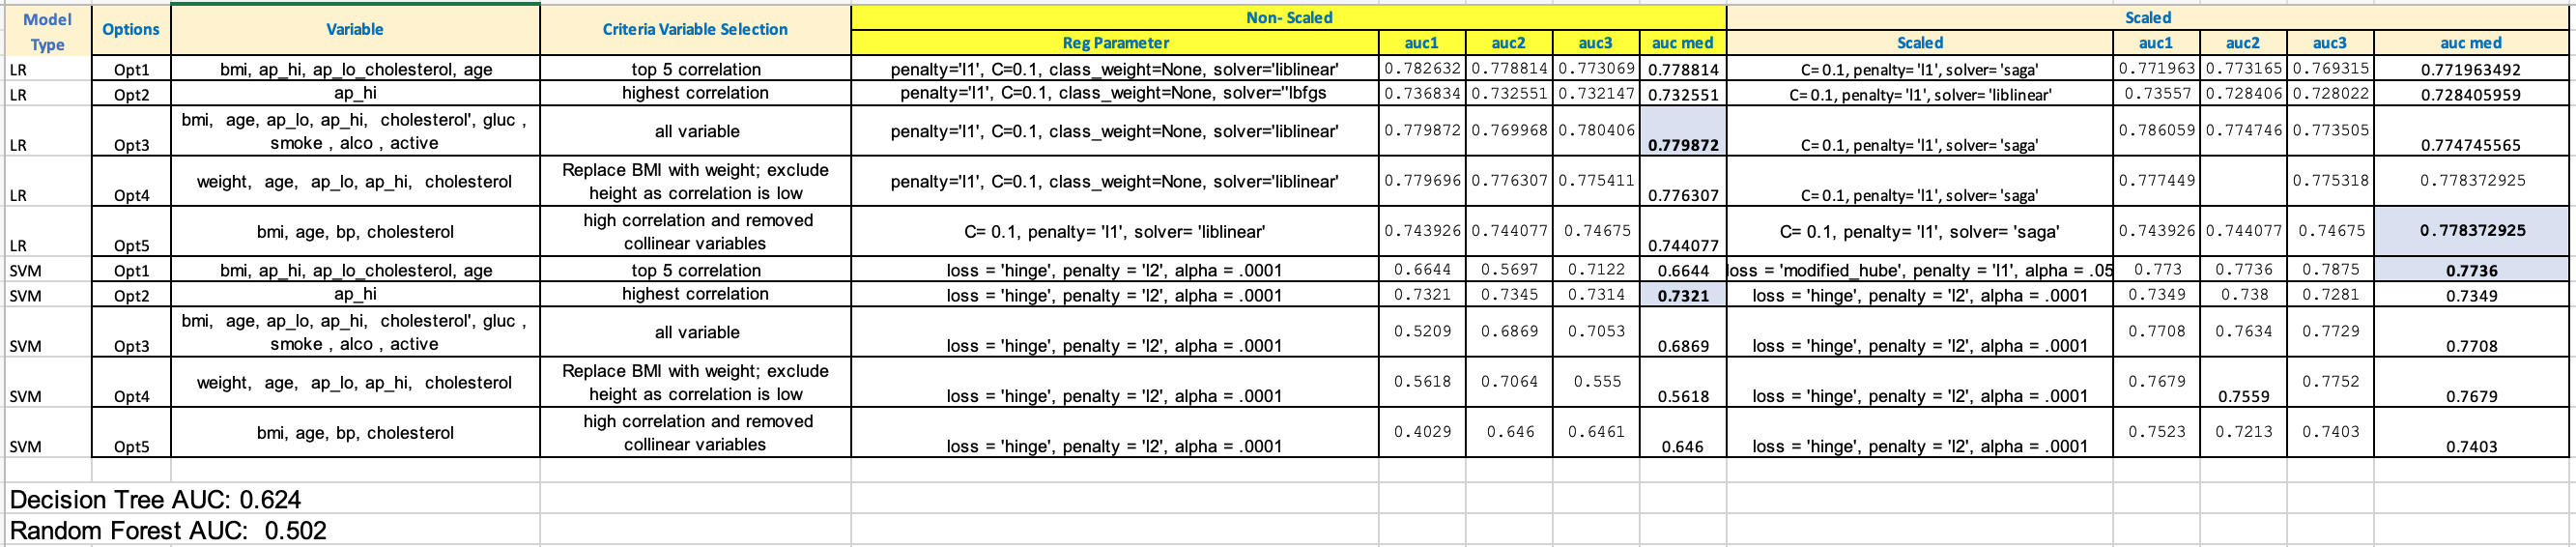

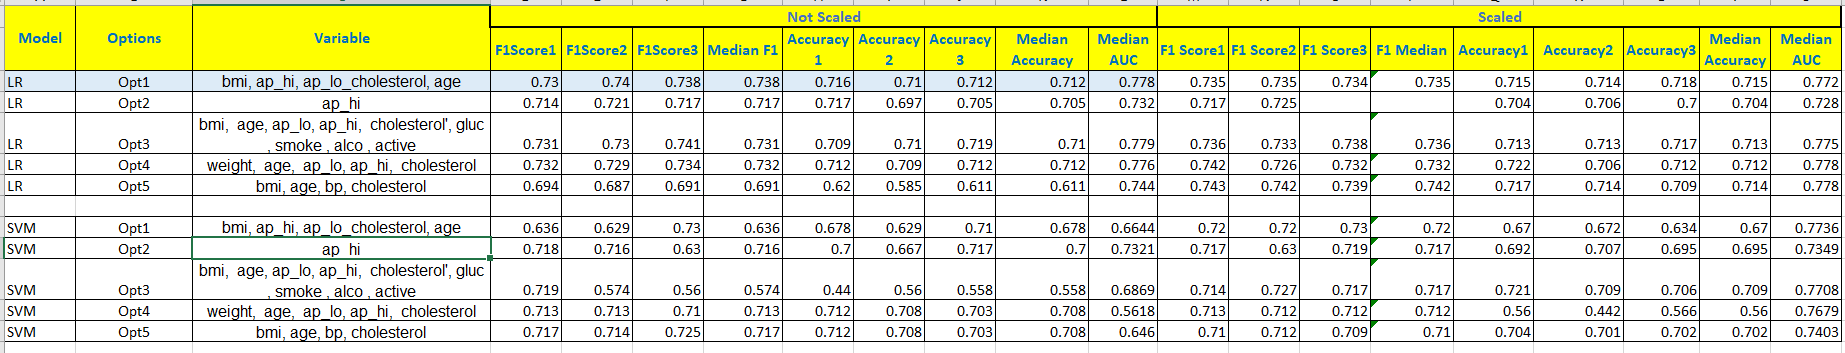

# Beginning of Model Analysis

First we will show our Logistic Regression Analysis, since that resulted in our preferred model.   Then we will describe our SVM analysis since that gave us our secondary model.

For the sake of brevity, only models for variable options 1 and 3 are shown for the Logistic Regression models, and only variable options 1 and 2 are shown for the SVM models. The remaining models' metrics are summarized in the charts above, and their details can be found in the appendix.

We also ran Decision Tree and Random Forest Models.   They gave us much lower AUC scores, so we rejected them as well. Results of these models are in our appendix.

## Train Test Split

We chose to do a cross validation using 3 repetitions of 80% train and 20% test. We thought an 80/20 split was good to use most of our data for training while still having enough for testing. We chose 3 repetitions because it is enough repetitions to give us a sense of the stability of the model while not being so many as to take too long to run.

We use this cross validation method on all of our model options.

In [6]:
#our target variable is cardio
y = df['cardio'].values

#make CV spit 80/20 object
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


## Logistic Regression

 There are multiple parameters that can help build a Logistic  Regression model listed below with the default value.  


*(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None])*



However, our team decided to focus on few critical parameters in tuning process like C, solver and penalty. 



Hyperparameters sets the algorithm that can be adjusted to optimize performance, these are the knobs to generate optimal outcome. These Hyperparameters in machine learning model help define your model architecture. Leveraging grid search optimal automated exploration is launched to find the optimal parameter value to extract best model architecture. 

The project Grid search approach was used to tune the parameters of the model. Grid search is an approach to hyperparameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. However, grid search suffers from the curse of dimensionality: the number of times required to evaluate the model during hyperparameter optimization grows exponentially in the number of parameters. 

The other popular method is Random Search. It is performed by evaluating n uniformly random points in the hyperparameter space and select the one producing the best performance. The drawback of random search is unnecessarily high variance. The method is, after all, entirely random, and uses no intelligence in selecting which points to try. You are relying on luck to get good results.

In the model building excises Grid Search was used, and to overcome the curse of dimensionality, hyper parameter list was highly evaluated and one making maxim impact were chosen. In the model tuning process, three parameters were considered: C, penalty and Solver. 

<b>C:</b> This controls the complexity and simplicity of model. However, complexity can lead to over fitting vs. simplicity will lead to under fitting. Small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C the power of regularization is decreased which allows the model to increase its complexity, and therefore, overfit the data. 

<b>Penalty:</b> This project uses two penalties. L1 and L2. The Penalty is used to specify the penalization method of the coefficients of noncontributing or less contributing variables.
Lasso (L1) performs feature selection by shrinking the less important feature’s coefficient to zero.
Ridge (L2) all variables are included in the model, though some are shrunk (but not to zero like L1 Penalty. Less computationally intensive than lasso.
Both penalty values restrict solver choices. It is critical to choose the right combination of Penalty.



<b>Solver:</b> Are the algorithm used in Logistic Regression to predict the outcome. Default value is lbfgs. other possible values (to list few) are, liblinear, sag and saga.
liblinear − It is a good choice for small datasets. It also handles L1 penalty. For multiclass problems, it is limited to one-versus-rest schemes.
lbfgs − For multiclass problems, it handles multinomial loss. It also handles only L2 penalty.
saga − It is a good choice for large datasets. For multiclass problems, it also handles multinomial loss. Along with L1 penalty, it also supports ‘elasticnet’ penalty.
sag − It is also used for large datasets. For multiclass problems, it also handles multinomial loss.



<b>Ref:</b> 
https://sigopt.com/blog/common-problems-in-hyperparameter-optimization

https://towardsdatascience.com/hyper-parameter-tuning-and-model-selection-like-a-movie-star-a884b8ee8d





## Option 1: BMI, ap_hi, ap_lo, cholesterol, age

Option 1 includes the following variables: bmi, ap_hi, ap_lo, cholesterol, age <br> 
These variables had the highest correlation to the cardio response variable.

We examine option 1 with data scaled and un-scaled. The un-scaled model became our most preferred model.

In [7]:
#set X with our desired variables
X = df[['bmi', 'ap_hi', 'ap_lo','cholesterol','age']].values 

### Un-scaled

In this section, we create a model with Option 1 variables using un-scaled data.

#### Hyperparameter Tuning

Here, we tune the hyperparameters for the model. We get the highest AUC of 0.777084 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [8]:
#make a grid search for logistic regression

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)



GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l2'],
                          'solver': ['lbfgs']}],
    

In [9]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.773463 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.773446 (0.002192) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.773395 (0.002225) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.773385 (0.002209) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.773463 (0.002185) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.773426 (0.002193) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.688654 (0.062151) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.687333 (0.059476) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.646686 (0.004599) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.646686 (0.004600) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.646687 (0.004600) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [10]:
fav_lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' )

#### Metrics

Here we show the accuracy metrics for the model. It has an AUC of .77, f1 score of .73, and accuracy of .71.

In [11]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    print("====Iteration",iter_num," ====")
    #Show AUC
    auc = mt.roc_auc_score(y_test,y_prob)
    print("auc", auc )
    
    #Show confusion matrix
    conf = mt.confusion_matrix(y_test,y_hat)
    print("confusion matrix\n",conf)
    
    # Show the Classification Report
    print(mt.classification_report(y_test,y_hat))
    
    iter_num+=1

NameError: name 'lr_clf' is not defined

### Scaled 

In this section, we create a model with Option 1 variables using scaled data.

#### Hyperparameter Tuning

Here, we tune the hyperparameters for the model. We get the highest AUC of 0.7768 using {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

In [ ]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))

In [ ]:
lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))


#### Metrics

Here we show the accuracy metrics for the model. It has an AUC of .77, accuracy of .71, and f1 score of .73.

In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    print("====Iteration",iter_num," ====")
    #Show AUC
    auc = mt.roc_auc_score(y_test,y_prob)
    print("auc", auc )
    
    #Show confusion matrix
    conf = mt.confusion_matrix(y_test,y_hat)
    print("confusion matrix\n",conf)
    
    # Show the Classification Report
    print(mt.classification_report(y_test,y_hat))
    
    iter_num+=1

## Logistic Regression Option 3.  Variables: BMI, age, ap_lo, ap_hi, cholesterol, gluc, smoke, alco, active

Option 3 is a model with all of the significant variables: bmi,  age, ap_lo, ap_hi,  cholesterol, gluc , smoke , alco , active.  It does not include ID and Gender.

Note: We skipped showing option 2, and we will skip 4 and 5 also, as their code is in the appendix. We include option 3 here as the one to show our process because option 3 was the runner up in performance.

In [ ]:
# set X with our variables of interest
X = df[['bmi','age','ap_lo','ap_hi','cholesterol','gluc','smoke','alco','active']].values 

### Un-Scaled

In this section, we create a model with Option 3 variables using un-scaled data.

#### Hyperparameter Tuning

Here, we tune the hyperparameters for the model. We get the highest AUC of 0.777614 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
#make a grid search for logistic regression
param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))

In [ ]:
# set our classifier with the best hyperparameters found
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) 



#### Metrics

Here we show the accuracy metrics for the model. It has an AUC of .77, accuracy of .71, and f1 score of .73.

In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    print("====Iteration",iter_num," ====")
    #Show AUC
    auc = mt.roc_auc_score(y_test,y_prob)
    print("auc", auc )
    
    #Show confusion matrix
    conf = mt.confusion_matrix(y_test,y_hat)
    print("confusion matrix\n",conf)
    
    # Show the Classification Report
    print(mt.classification_report(y_test,y_hat))
    
    iter_num+=1

### Scaled

In this section, we create a model with Option 3 variables using scaled data.

#### Hyperparameter Tuning

Here, we tune the hyperparameters for the model. We get the highest AUC of 0.777614 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))

In [ ]:
# set our classifier with the best hyperparameters found
lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))

#### Metrics 

Here we show the metrics for Option 3 Logistic Regression with Scaled Data. It has an AUC of .77, f1 score of .74, and accuracy of .72.

In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    print("====Iteration",iter_num," ====")
    #Show AUC
    auc = mt.roc_auc_score(y_test,y_prob)
    print("auc", auc )
    
    #Show confusion matrix
    conf = mt.confusion_matrix(y_test,y_hat)
    print("confusion matrix\n",conf)
    
    # Show the Classification Report
    print(mt.classification_report(y_test,y_hat))
    
    iter_num+=1

### Preferred Logistic Model

As mentioned in the summary chart at the top of this file, we compared the AUCs of models with variable options 1-5, each with scaled and un-scaled versions. We found that the AUC of the model with variable option 1 un-scaled was tied with the option 3 un-scaled model, with an AUC of .779, so we went with option 1 as it is the simpler model. The numbers presented may not be entirely consistent with the output of the code run above due to some randomness in cross validation.

This winning model from above will now be tuned further below.

## Logistic Regression Further Tuning for Preferred Model (Option 1, Un-scaled)

Because we compared our models so far using AUC, it is appropriate that we further tune our favorite model from above to the best f1 score using the alpha value which is the probability threshold at which to classify a point as positive or negative.

###  ROC Curve   Preferred Model (Option 1, Un-scaled)

This is the ROC curve for our preferred model, Logistic Regression Option 1 with Un-Scaled Data. The ROC curve shows that the threshold with the best precision and recall should lie between alpha=.2 and alpha=.6.

In [ ]:

fav_lr_clf.fit(X_train, y_train)

# predict probabilities
fav_lr_probs = fav_lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
fav_lr_probs = fav_lr_probs[:, 1]
# calculate scores
fav_lr_auc = roc_auc_score(y_test, fav_lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (fav_lr_auc))
# calculate roc curves
fav_lr_fpr, fav_lr_tpr, _ = roc_curve(y_test, fav_lr_probs)
# plot the roc curve for the model
pyplot.plot(fav_lr_fpr, fav_lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Tuning Alpha

The following shows accuracy of the model for alpha values between .2 and .6.  The optimal alpha value for our model is .40.  This alpha value gives us an f1 score of .760. Therefore, we will classify a point as a cardiac event if it has a predicted probability greater than .40.

In [ ]:
alphas = np.arange(.2, .6, .02)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, y_prob))
    f1 = mt.f1_score(y_test, y_hat)
    print('alpha %f : f1=%.3f' % (alpha, f1))


Having picked an alpha of .4 for our model, the f1 score is .759, the precision is .698, and recall is .832. Previously with the default alpha, the precision was .76, recall was .706. The new model reduced the precision somewhat but increased recall, and this tradeoff is worthwhile to reduce the number of people who would receive false negative results and thereby have a cardiac event without proper treatment.

In [ ]:
#old metrics
y_hat = fav_lr_clf.predict(X_test)
f1 = mt.f1_score(y_test, y_hat)
precision = mt.precision_score(y_test, y_hat)
recall = mt.recall_score(y_test, y_hat)
print('Old default alpha (.5) : f1=%.3f, precision=%.3f, recall=%.3f' % (f1, precision, recall))

#new metrics
alpha = .4
y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, y_prob))
f1 = mt.f1_score(y_test, y_hat)
precision = mt.precision_score(y_test, y_hat)
recall = mt.recall_score(y_test, y_hat)
print('New alpha %f : f1=%.3f, precision=%.3f, recall=%.3f' % (alpha, f1, precision, recall))


## Analysis of Logistic Regression Model Performance

The F1 score for this model is .76.   The F1 score is a harmonic mean of precision and recall.  It is calculated from the precision and recall of the test. 

The model has a precision of .698. Precision represents the number of correctly identified positive results divided by the number of all positive results. 

The model has a recall of .83 for cardiac event as the positive class. The recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive. 


## Stability of the Models

When analyzing the models prior to tuning for alpha, the selection of the variables for the logistic regression gave three stable models with consistent accuracy results of 71.3%, 71.1 %, and 70.8 %. The accuracy can be defined as the percentage of correctly classified instances (TP + TN)/(TP + TN + FP + FN) 
It also gave stable AUCs of 0.774, 0.777 and 0,773. 


# SVM Analysis

Using the same variable combination options, we created SVM models. Again, we compare both scaled and un-scaled versions. We obtain the metrics for each of the models, but here we only present models for variable option 2 and option 1. The rest of the models are summarized in the table at the top of the file, and their details are in the appendix. We chose to show option 2 here because it has only the variable ap_hi, and we consider it our baseline model. We show option 1 here because it had the best AUC of the SVM models that we compared.


For the SVM models, we used the SGDClassifier which uses stochastic gradient descent to optimize the weights. We chose to use stochastic gradient descent because of the size of our data (50k+ rows) which was too large and slow to run using batch gradient descent. However, for the purposes of analyzing support vectors, we will later take a small sample of our data to run using SVC.

## SVM Baseline model Option 2:  (ap_hi only)

Here we build baseline models using just ap_hi as a predictor.

### Un-scaled

Here we show the metrics of the model using variable option 2, un-scaled. It has a median AUC of .74, f1 score of .71, and accuracy of .70.

In [ ]:
X = df[['ap_hi']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print("AUC Values:", aucs)
 
f1score = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'f1')
print("F1 Score Values:", f1score)

acc = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'accuracy')
print("Accuracy Values: ", acc)

### Scaled

Here we show the metrics of the SVM model using variable option 2, scaled. It has a median AUC of .73, f1 score of .72, and accuracy of .67.

In [ ]:
X = df[['ap_hi']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print("AUC Values:", aucs)

f1score = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'f1')
print("F1 Score Values:", f1score)

acc = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'accuracy')
print("Accuracy Values: ", acc)

## Option 1:  BMI, age, ap_hi, ap_lo, cholesterol

These are the variables which are most correlated to the response varaible.  It is Option 1 in our analysis chart.

### Un-scaled 

Here we create a SVM model using variable option 1, un-scaled. It has median AUC of .67, f1 of .69, and accuracy of .45. This model does not perform very well, which is expected because SVM is sensitive to data not being scaled.

In [ ]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print("AUC Values:", aucs)

f1score = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'f1')
print("F1 Score Values:", f1score)

acc = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'accuracy')
print("Accuracy Values: ", acc)

### Scaled

Here is the model using variable option 1, scaled. It has median AUC of .77, f1 of .71, and accuracy of .71. This is our most preferred SVM model.

In [ ]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print("AUC Values:", aucs)

f1score = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'f1')
print("F1 Score Values:", f1score)

acc = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'accuracy')
print("Accuracy Values: ", acc)

### Preferred SVM Model

As mentioned in the summary chart at the top of this file, we compared the AUCs of models with variable options 1-5, each with scaled and un-scaled versions. We found that the AUC of the model with variable option 1 un-scaled was the best of the SVM models, with an AUC of .779. We will now continue with tuning this model.

## SVM Hyperparameter Tuning

Having selected the SVM model variables, we continue with tuning the hyperparameters of the model. We do a grid search of all the combinations of available hyperparameters that we consider important to tune. Because we use the SGDClassifier, other hyperparameters which would have been of interest, such as kernel type, were not available for us to tune.

The hyperparameters that we chose to tune are Penalty and Alpha.
* Penalty is the regularization that is used for the model. Penalty has options 'l1', 'l2', and 'elasticnet'. We try all these options.
* Alpha is a constant multiplied with the regularization term, which controls the strength of the regularization. The higher the value, the stronger the regularization. For alpha, we try values .001, .01, .05, .1, .5, and 1.

Note: the loss function "modified_huber" is used for SVM, and is the only loss function considered here because it is the only one that allows for a continuous probability prediction, which we will need to use for tuning alpha later.

From our hyperparameter tuning, we got that the best hyperparameters are alpha=.05, penalty='l1'. This model has an AUC of .776.

In [ ]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

param_grid = [
  {'classifier__loss': ['modified_huber'],
   'classifier__penalty': ['l1', 'l2', 'elasticnet'],
   'classifier__alpha': [.001, .01, .05, .1, .5, 1]}
 ]

svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier())])

fav_svm_clf = GridSearchCV(svm, param_grid, scoring="roc_auc")
fav_svm_clf.fit(X, y)

print("Best auc: %f using %s" % (fav_svm_clf.best_score_, fav_svm_clf.best_params_))

means = fav_svm_clf.cv_results_['mean_test_score']
stds = fav_svm_clf.cv_results_['std_test_score']
params = fav_svm_clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Probability Calibration - SVM Option 1

It is useful to calibrate SVM models because they often output probabilities that are not aligned to the actual probabilities of being classified as one class or another.

The calibrated model has median AUC .78, f1 score .73, and accuracy .71.

In [ ]:
#https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/

model = fav_svm_clf.best_estimator_ #this was alpha=.05, loss='modified_huber', penalty='l1'
calibrator = CalibratedClassifierCV(model, cv=3)

aucs = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'roc_auc')
print("AUC Score Values:", aucs)

f1score = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'f1')
print("F1 Score Values:", f1score)

acc = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'accuracy')
print("Accuracy Values: ", acc)

## SVM Optimal Alpha Value

After selecting the model with the best AUC, it is appropriate to tune the model for alpha, the threshold at which to predict a point as the positive class. This will help us determine the alpha that will get us the best f1 score for this model

### ROC Curve

The ROC curve for our model shows that alpha between .2 and .6 will likely be where we can find the best f1 score.

In [ ]:
# roc curve and auc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

std_scl = StandardScaler()
scl_obj = std_scl.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test) 

model.fit(X_train, y_train)

# predict probabilities
svm_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# calculate scores
svm_auc = roc_auc_score(y_test, svm_probs)
# summarize scores\
print('SVM Model ROC AUC=%.3f' % (svm_auc))
# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
# plot the roc curve for the model
pyplot.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Tuning Alpha

The below shows f1 scores for alphas from .2 to .6. The highest f1 score is .759 at alpha=.40.

In [ ]:
alphas = np.arange(.2, .6, .02)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    f1 = mt.f1_score(y_test, y_hat)
    print('alpha %f : f1 score=%.3f' % (alpha, f1))



Having picked an alpha of .4 for our model, the f1 score is .761, the precision is .887, and recall is .700. Previously with the default binary predictions, the precision was .76, recall was .70. The new model reduced the precision somewhat but increased recall, and this tradeoff is worthwhile to reduce the number of people who would receive false negative results and thereby have a cardiac event without proper treatment.

In [ ]:
#old metrics
y_hat = fav_svm_clf.predict(X_test)
f1 = mt.f1_score(y_test, y_hat)
precision = mt.precision_score(y_test, y_hat)
recall = mt.recall_score(y_test, y_hat)
print('Old default binary predictions: f1=%.3f, precision=%.3f, recall=%.3f' % (f1, precision, recall))

#new metrics
alpha = .4
y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
f1 = mt.f1_score(y_test, y_hat)
precision = mt.precision_score(y_test, y_hat)
recall = mt.recall_score(y_test, y_hat)
print('New alpha %f : f1=%.3f, precision=%.3f, recall=%.3f' % (alpha, f1, precision, recall))

# Model 1 Insights

##  Preferred Model Logistic Regression Option 1 Un-Scaled 

From the analysis and comparison of logistic regression models in the section above, th preferred logistic model uses the variables: bmi, ap_hi, ap_lo_cholesterol, age.

This section contains interpretation of the coefficient weights of the model.


## Interpretation of the Variable Weights

As you can see in the graph below, cholesterol has the highest weight to predict a cardiac event.  It has a weight of 0.409. It is followed by systolic blood pressure (ap_hi), which has a weight of 0.06, and diastolic blood pressure(ap_lo), which has a weight of 0.014.The weights of the coefficients show that the systolic pressure (ap_hi) more heavily impacts the prediction of a cardiac event than diastolic blood pressure (ap_lo).  BMI has more weight to predict than diastolic blood pressure (ap_lo) but less than ap_hi and cholesterol.   BMI has a weight of 0.019. Finally, with the lowest weight to predict cardiac events is the age with a weight of 0.0001.



In [ ]:
# interpret the weights

# iterate over the coefficients
weights = fav_lr_clf.coef_.T # take transpose to make a column vector
variable_names = ['bmi','ap_hi','ap_lo','cholesterol','age']
 
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

## Graph of the weights

This graph, described above, shows the weights of the variables for our model.

In [ ]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(fav_lr_clf.coef_[0],index=variable_names)
weights.plot(kind='bar')
plt.show()

##  Summary of Model 1 Insight

In our preferred model, the weight of the cholesterol variable is the most significant factor in predicting cardiac events. Our EDA analysis showed that systolic blood pressure (ap_hi) had the highest correlation to the cardiac events.  This shows that ap_hi is still a significant factor.   It is not suprising, based on subject matter expert knowlege, that cholesterol is a large contributing factor to cardiac events. All of the variables we picked for this model are known to be significant factors to predicting cardiac events.

# Model 2 Insight

Our preferred SVM model with scaled data uses the same Option 1 variables as our overall favorite model: the logistic regression model with un-scaled data.   The varaibles used are: systolic blood pressure (ap_hi), diastolic blood pressure (ap_lo), BMI, Age and Cholesterol.

Below we compare the support vectors to the original distribution of the data for these individual variables.

For this model, we have an AUC score of 78% and Accuracy of 71% and an F1 Score of 73%.


You can see how the selection of the variables for the logistic regression gives us three stable models in the training split with accuracy result of 71 %.The accuracy can be defined as the percentage of correctly classified instances (TP + TN)/(TP + TN + FP + FN) 
It also gives us a stable AUC of 71%.  The plot of Sensitivity versus (1- Specificity) curve is shown below.

 The F1 score is calculated from the precision and recall of the test, where the precision is the number of correctly identified positive results divided by the number of all positive results, including those not identified correctly.  The recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive.  The F1 score is the harmonic mean of the precision and recall. The F1 score is 73% for cardiac events.

In [ ]:
#https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/

model = fav_svm_clf.best_estimator_ #this was alpha=.1, loss='modified_huber', penalty='elasticnet'
calibrator = CalibratedClassifierCV(model, cv=3)

aucs = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

In [ ]:
f1score = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'f1')
print("F1 Score Values:", f1score)

acc = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'accuracy')
print("Accuracy Values: ", acc)

## Support Vector Analysis

This section analyzes the support vectors. The analysis in this section is created not with the model selected from above, but a new toy model created with a small subsample of the data points so that we could view the support vectors using the SVC function.

In [ ]:
    
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']].values
cv_object =  ShuffleSplit(n_splits=1,
                         test_size  = 0.9)

#train test split
for train_indices, test_indices in cv_object.split(X, y):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    scl_obj = StandardScaler()
    scl_obj.fit(X_train)
    
    X_train_scaled = scl_obj.transform(X_train)
    X_test_scaled = scl_obj.transform(X_test) 
        

# train the model
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object
    
# make a dataframe of the training data
df_tested_on = df.iloc[train_indices].copy() # saved from above, the indices chosen for training

# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['cardio'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df['cardio'] = y # also add it back in for the original data
df_support.info()

## Explanation of Support Vectors

This model used 3412 support vectors out of 5305 training points, which is a large number of support vectors.  These 3412 vectors were divided into 1711 and 1701 for the results of the cardiac events.  This is a large number of support vectors and shows that we have an even split in the data. In the graphs below, there is a close match between the support vectors and the variables which means that a lot of the data was close to the vector boundaries.

In [ ]:
# the data that was used for training in our SVM model
X_train.shape

In [ ]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

### Plot SVM Vectors - ap_hi, ap_lo, bmi_age, cholesterol

The graphs below show the distribution of support vectors on the left, and the distribution of the original data on the right side. We can see that among the support vectors, the distribution of points across the variables are very similar between the cardio and non-cardio groups. Among the original data, the distribution of points is less even between the cardio and non-cardio groups.

In [ ]:
# group the original data and the support vectors
df_grouped_support = df_support.groupby(['cardio'])
df_grouped = df.groupby(['cardio'])

# plot KDE of Different variables
 
vars_to_plot =['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']

for v in vars_to_plot:
    pyplot.figure(figsize=(10,4))
    # plot support vector stats
    pyplot.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    pyplot.legend(['noncardio','cardio'])
    pyplot.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    pyplot.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    pyplot.legend(['noncardio','cardio'])
    pyplot.title(v+' (Original)')




# Advantages and Disadvantages

Advantages of Logistic Regression
* Logistic regression is easier to implement, interpret, and very efficient to train.
* It makes no assumptions about distributions of classes in feature space.
* It can easily extend to multiple classes(multinomial regression) and a natural probabilistic view of class predictions.
* It not only provides a measure of how appropriate a predictor(coefficient size)is, but also its direction of association (positive or negative).
* It is very fast at classifying unknown records.
* Good accuracy for many simple data sets and it performs well when the dataset is linearly separable.
* It can interpret model coefficients as indicators of feature importance.
* Logistic regression is less inclined to over-fitting but it can overfit in high dimensional datasets.One may consider Regularization (L1 and L2) techniques to avoid over-fittingin these scenarios.

Disadvantages of Logistic Regression
* If the number of observations is lesser than the number of features, Logistic Regression should not be used, otherwise, it may lead to overfitting.
* The major limitation of Logistic Regression is the assumption of linearity between the dependent variable and the independent variables.
* It can only be used to predict discrete functions. Hence, the dependent variable of Logistic Regression is bound to the discrete number set.
* Logistic Regression requires average or no multicollinearity between independent variables.
* It is tough to obtain complex relationships using logistic regression. More powerful and compact algorithms such as Neural Networks can easily outperform this algorithm.
* In Linear Regression independent and dependent variables are related linearly. But Logistic Regression needs that independent variables are linearly related to the log odds (log(p/(1-p)).


Advantages of Support Vector Machine (SVM)

1. Regularization capabilities: SVM has L2 Regularization feature. So, it has good generalization capabilities which prevent it from over-fitting.

2. Handles non-linear data efficiently: SVM can efficiently handle non-linear data using Kernel trick.

3. Solves both Classification and Regression problems: SVM can be used to solve both classification and regression problems. SVM is used for classification problems while SVR (Support Vector Regression) is used for regression problems.

4. Stability: A small change to the data does not greatly affect the hyperplane and hence the SVM. So the SVM model is stable.

Disadvantages of Support Vector Machine (SVM)

1. Choosing an appropriate Kernel function is difficult: Choosing an appropriate Kernel function (to handle the non-linear data) is not an easy task. It could be tricky and complex. In case of using a high dimension Kernel, you might generate too many support vectors which reduce the training speed drastically. 

2. Extensive memory requirement: Algorithmic complexity and memory requirements of SVM are very high. You need a lot of memory since you have to store all the support vectors in the memory and this number grows abruptly with the training dataset size.

3. Requires Feature Scaling: One must do feature scaling of variables before applying SVM.

4. Long training time: SVM takes a long training time on large datasets.

5. Difficult to interpret: SVM model is difficult to understand and interpret by human beings unlike Decision Trees.


### Comparison of ROCs

Here, we plot both of our model options on the same plot for comparison. The logistic regression ROC is shown in blue on the plot, and the SVM ROC is shown in orange. They are very closely lined up to each other, which is expected, seeing as the AUCs were very close to one another. This is an indication that both the logistic and the svm models have similar performance.

In [ ]:
fav_svm_clf.fit(X_train, y_train)
fav_lr_clf.fit(X_train, y_train)

# predict probabilities
fav_lr_probs = fav_lr_clf.predict_proba(X_test)
fav_svm_probs = fav_svm_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
fav_lr_probs = fav_lr_probs[:, 1]
fav_svm_probs = fav_svm_probs[:, 1]
# calculate scores
fav_lr_auc = roc_auc_score(y_test, fav_lr_probs)
fav_svm_auc = roc_auc_score(y_test, fav_svm_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (fav_lr_auc))
print('SVM: ROC AUC=%.3f' % (fav_svm_auc))
# calculate roc curves
fav_lr_fpr, fav_lr_tpr, _ = roc_curve(y_test, fav_lr_probs)
fav_svm_fpr, fav_svm_tpr, _ = roc_curve(y_test, fav_svm_probs)
# plot the roc curve for the model
pyplot.plot(fav_lr_fpr, fav_lr_tpr, marker='.', label='Logistic')
pyplot.plot(fav_svm_fpr, fav_svm_tpr, marker=',', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Comparing Our Models

Our most preferred logistic regression model had AUC of 0.777, f1=0.759, precision=0.698, recall=0.832.
Our best SVM model had AUC of 0.778, f1=0.761, precision=0.667, recall=0.887. 

Based on the AUC and f1 score, the SVM had slightly higher performance than the logistic regression model. The scores are very similar though, and the difference may just be due to sampling chance. Logistic regression models, having interpretable coefficients and variable weights makes the logistic regression more favorable, because that allows us to explain the insights of the model to stakeholders. In contrast, it was hard to explain the content of the support vectors. Also, the SVM model uses scaled data which is even more difficult to interpret. In addition, the SVM takes longer to train. All in all, we feel that the Logistic Regression model is our preferred model.

## ---------------------------

# Appendix

In this section we have placed the remaining models from our chart above.   They were all determined to be less accurate and were rejected, but we placed them here to show a comparason of the different variable options for SVM and Logistic regression with scaled and un-scaled data

## Decision Tree Model

In [201]:
from sklearn.model_selection import train_test_split
X = df[['bmi', 'ap_hi', 'ap_lo','cholesterol','age']]
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

#### Training a Decision Tree Model
Let's start by training a single decision tree first!

** Import DecisionTreeClassifier**

In [202]:
from sklearn.tree import DecisionTreeClassifier

Create an instance of DecisionTreeClassifier() called dtree and fit it to the training data.

In [203]:
dtree = DecisionTreeClassifier()

In [205]:
dtree = DecisionTreeClassifier(criterion='entrophy', max_depth=5, 
                                 min_samples_split=5000,min_samples_leaf=1, 
                                max_leaf_nodes=None)

In [206]:
### best so far
dtree = DecisionTreeClassifier(criterion='gini', max_depth=5, 
                                 min_samples_split=1000,min_samples_leaf=1, 
                                max_leaf_nodes=None)

In [207]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

#### Predictions and Evaluation of Decision Tree

Create predictions from the test set and create a classification report and a confusion matrix

In [208]:
predictions = dtree.predict(X_test)

In [209]:
from sklearn.metrics import classification_report,confusion_matrix

[Text(156.93750000000003, 199.32, 'X[1] <= 129.5\nentropy = 0.493\nsamples = 42442\nvalue = [18727, 23715]'),
 Text(75.33000000000001, 163.07999999999998, 'X[4] <= 20150.5\nentropy = 0.46\nsamples = 21282\nvalue = [13643, 7639]'),
 Text(41.85000000000001, 126.83999999999999, 'X[3] <= 2.5\nentropy = 0.401\nsamples = 12480\nvalue = [9013, 3467]'),
 Text(33.480000000000004, 90.6, 'X[4] <= 16100.5\nentropy = 0.385\nsamples = 11864\nvalue = [8776, 3088]'),
 Text(16.740000000000002, 54.359999999999985, 'X[3] <= 1.5\nentropy = 0.287\nsamples = 2812\nvalue = [2324, 488]'),
 Text(8.370000000000001, 18.119999999999976, 'entropy = 0.265\nsamples = 2561\nvalue = [2159, 402]'),
 Text(25.110000000000003, 18.119999999999976, 'entropy = 0.45\nsamples = 251\nvalue = [165, 86]'),
 Text(50.220000000000006, 54.359999999999985, 'X[0] <= 27.886\nentropy = 0.409\nsamples = 9052\nvalue = [6452, 2600]'),
 Text(41.85000000000001, 18.119999999999976, 'entropy = 0.389\nsamples = 6393\nvalue = [4702, 1691]'),
 Tex

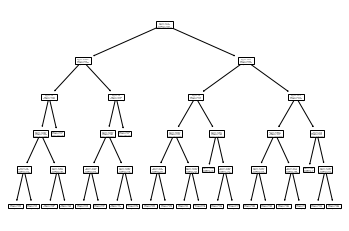

In [210]:
from sklearn import tree
tree.plot_tree(dtree)

In [211]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      4679
           1       0.76      0.74      0.75      5932

    accuracy                           0.72     10611
   macro avg       0.72      0.72      0.72     10611
weighted avg       0.72      0.72      0.72     10611



In [212]:

from sklearn import metrics as mt
auc = mt.roc_auc_score(y_test,predictions)
print("auc", auc )

auc 0.72015434019839


### Training the Random Forest model
Create an instance of the RandomForestClassifier class and fit it to our training data from the previous step.

In [213]:
from sklearn.ensemble import RandomForestClassifier

In [214]:
rfc = RandomForestClassifier(n_estimators=1600,max_depth=5)

In [215]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [216]:

from sklearn import metrics as mt
auc = mt.roc_auc_score(y_test,predictions)
print("auc", auc )

auc 0.72015434019839


### Predictions and Evaluation
Let's predict off the y_test values and evaluate our model.

** Predict the class of not.fully.paid for the X_test data.**

In [217]:
predictions = rfc.predict(X_test)

Now create a classification report from the results.

In [218]:
from sklearn.metrics import classification_report,confusion_matrix

In [219]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.66      0.73      0.70      4679
           1       0.77      0.71      0.74      5932

    accuracy                           0.72     10611
   macro avg       0.72      0.72      0.72     10611
weighted avg       0.72      0.72      0.72     10611



In [222]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

yhat = np.zeros(y.shape) # we will fill this with predictions

scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10)



In [223]:
# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=3)



In [225]:
cv.split(test)

TypeError: split() missing 1 required positional argument: 'y'

In [226]:
# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('KNN accuracy', total_accuracy)

C:\Users\Ellen\Anaconda3\lib\site-packages\pandas\core\series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').